### 한 픽셀 만 이용해서 얼마나 유의미한 예측을 할 수 있는지 실험

In [1]:
import torch
from torchvision import transforms
from utils.utils import train_model, TiffDataset, DualTransform
import torch
from torch.utils.data import DataLoader

In [2]:
# 데이터 경로 설정
target = "height"
large_tif_dir = "../../data/source_data/with_s2/"  # 원천 데이터 TIFF 파일이 있는 폴더
label_dir = f"../../data/label_data/{target}"  # 대응하는 레이블 TIFF 파일이 있는 폴더
file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"]  # 사용할 TIFF 파일 리스트

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
base_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.float().squeeze(-1).squeeze(-1)),  # uint16 → float 변환 -> squeeze
])

# DualTransform을 적용하여 입력과 레이블을 변환
dual_transform = DualTransform(base_transform, base_transform)

In [4]:
test_filter = lambda box_number: (box_number % 9 == 0 or box_number % 9 == 5) #test지역 선별

In [5]:
patch_size = 1
stride = 1

# 데이터셋 생성
train_dataset = TiffDataset(large_tif_dir, label_dir, file_list, patch_size=patch_size, stride=stride, box_filter_fn=lambda box_number: not test_filter(box_number), transform=dual_transform)
val_dataset = TiffDataset(large_tif_dir, label_dir, file_list, patch_size=patch_size, stride=stride, box_filter_fn=test_filter, transform=dual_transform)
# train_dataset = TiffDataset(large_tif_dir, label_dir, file_list, patch_size=patch_size, stride=stride, box_filter_fn=lambda box_number: box_number%31 == 0, transform=dual_transform)
# val_dataset = TiffDataset(large_tif_dir, label_dir, file_list, patch_size=patch_size, stride=stride, box_filter_fn=lambda box_number: box_number%37 == 0, transform=dual_transform)
# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

# 개선된 DNN 모델 정의
class DNN(nn.Module):
    def __init__(self, input_dim=108, hidden_dim=128, output_dim=1):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)  # 과적합 방지
        self.residual = nn.Linear(input_dim, hidden_dim)  # Residual Connection

    def forward(self, x):
        residual = self.residual(x)  # 입력을 변형해 residual로 전달
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)) + residual)  # Residual Connection 적용
        x = self.fc4(x)  # 최종 출력
        return x

# 모델, 손실 함수, 옵티마이저 초기화
model = DNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)  # AdamW로 가중치 감쇠 적용


In [8]:
num_epochs = 30
#checkpoints_dir = "./checkpoints/use_one_pixel"

best_model_state, train_losses, val_losses = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, patience=100, task_type = "r"
)
#os.makedirs(checkpoints_dir, exist_ok=True)
#torch.save(best_model_state, os.path.join(checkpoint_dir, f"DNN_{target}_{num_epochs}.pth"))
#model.load_state_dict(best_model_state)

Epoch 1/30 - Training:   0%|          | 0/41133 [00:00<?, ?it/s]

Epoch 1/30 - Validation: 100%|██████████| 11602/11602 [05:21<00:00, 36.07it/s]



Epoch [1/30], Train Loss: 43.0227, Train R² Score: -0.6295, Val Loss: 15.1981, Val R² Score: 0.4005



Epoch 2/30 - Validation: 100%|██████████| 11602/11602 [05:20<00:00, 36.17it/s]



Epoch [2/30], Train Loss: 10.9747, Train R² Score: 0.5843, Val Loss: 16.3655, Val R² Score: 0.3545



Epoch 3/30 - Validation: 100%|██████████| 11602/11602 [05:26<00:00, 35.55it/s]



Epoch [3/30], Train Loss: 10.5326, Train R² Score: 0.6011, Val Loss: 15.3356, Val R² Score: 0.3951



Epoch 4/30 - Validation: 100%|██████████| 11602/11602 [05:23<00:00, 35.89it/s]



Epoch [4/30], Train Loss: 10.3583, Train R² Score: 0.6077, Val Loss: 15.9243, Val R² Score: 0.3719



Epoch 5/30 - Training:  90%|████████▉ | 36854/41133 [19:32<2:06:38,  1.78s/it]

: 

: 

======================================================================================================================================

In [ ]:
import os
import rasterio
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import copy
import random

In [ ]:
# Hyperparameters
batch_size = 16
epochs = 10
learning_rate = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Custom Dataset
class SegmentationDataset(Dataset):
    def __init__(self, input_dir, label_dir, file_names):
        self.input_dir = input_dir
        self.label_dir = label_dir
        self.file_names = file_names

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]

        # Load input data
        with rasterio.open(os.path.join(self.input_dir, file_name)) as src:
            input_data = src.read()  # Shape: (channels, height, width)

        # Load label data
        with rasterio.open(os.path.join(self.label_dir, file_name)) as src:
            label_data = src.read(1)  # Shape: (height, width)

        # Convert to torch tensors
        input_data = torch.tensor(input_data, dtype=torch.float32)
        #label_data = torch.tensor(label_data, dtype=torch.long)
        
         # Handle data type based on the task
        if "수종" in self.label_dir:
            label_data = torch.tensor(label_data, dtype=torch.long)  # Segmentation task
        else:
            label_data = torch.tensor(label_data, dtype=torch.float32).unsqueeze(0)  # Regression task


        return input_data, label_data


In [ ]:
# U-Net Model
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.encoder1 = conv_block(in_channels, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)
        self.encoder4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = conv_block(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = conv_block(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))

        bottleneck = self.bottleneck(self.pool(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = self.decoder4(torch.cat((dec4, enc4), dim=1))

        dec3 = self.upconv3(dec4)
        dec3 = self.decoder3(torch.cat((dec3, enc3), dim=1))

        dec2 = self.upconv2(dec3)
        dec2 = self.decoder2(torch.cat((dec2, enc2), dim=1))

        dec1 = self.upconv1(dec2)
        dec1 = self.decoder1(torch.cat((dec1, enc1), dim=1))

        return self.final_conv(dec1)

In [ ]:
# Directories
target = ["수종", "임분고", "경급", "영급"]
input_dir = r"C:\Users\taebin\Desktop\my_study\capstone_design\data\jiri_toy_data_128\원천 데이터\concated"
label_base_dir = r"C:\Users\taebin\Desktop\my_study\capstone_design\data\jiri_toy_data_128\라벨링 데이터"


In [ ]:
# Prepare data
file_names = sorted(os.listdir(input_dir))  # Assumes matching files exist in both directories
train_files, val_files = train_test_split(file_names, test_size=0.2, random_state=42) #20%는 validation 데이터로 사용한다.

train_dataset = {}
val_dataset = {}
train_loader ={}
val_loader ={}

for target_name in target:
    label_dir = os.path.join(label_base_dir, target_name)
    train_dataset[target_name] = SegmentationDataset(input_dir, label_dir, train_files)
    val_dataset[target_name] = SegmentationDataset(input_dir, label_dir, val_files)
    train_loader[target_name] = DataLoader(train_dataset[target_name], batch_size=batch_size, shuffle=True)
    val_loader[target_name] = DataLoader(val_dataset[target_name], batch_size=batch_size, shuffle=False)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\taebin\\Desktop\\my_study\\capstone_design\\data\\jiri_toy_data_128\\원천 데이터\\concated'

In [ ]:
model = {}
criterion = {}
optimizer = {}

# Segmentation task: 수종
model['수종'] = UNet(in_channels=51, out_channels=5).to(device)
criterion['수종'] = nn.CrossEntropyLoss()
optimizer['수종'] = optim.Adam(model['수종'].parameters(), lr=learning_rate)

# Regression task: 임분고
model['임분고'] = UNet(in_channels=51, out_channels=1).to(device)
criterion['임분고'] = nn.MSELoss()  # Using Mean Squared Error for regression
optimizer['임분고'] = optim.Adam(model['임분고'].parameters(), lr=learning_rate)

# Repeat similar for 경급, 영급 if needed
model['경급'] = UNet(in_channels=51, out_channels=1).to(device)
criterion['경급'] = nn.MSELoss()
optimizer['경급'] = optim.Adam(model['경급'].parameters(), lr=learning_rate)

model['영급'] = UNet(in_channels=51, out_channels=1).to(device)
criterion['영급'] = nn.MSELoss()
optimizer['영급'] = optim.Adam(model['영급'].parameters(), lr=learning_rate)

In [ ]:
# model = {}
# criterion = {}
# optimizer = {}

# for target_name in target:
#     model[target_name] = UNet(in_channels=51, out_channels=5).to(device) #channel수 다르게 해 줘야함함
#     criterion[target_name] = nn.CrossEntropyLoss()
#     optimizer[target_name] = optim.Adam(model[target_name].parameters(), lr=learning_rate)

In [ ]:
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')  # Initialize best validation loss with infinity
    best_model = None  # Variable to store the best model
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
                
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

                # Forward pass
                val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, val_labels).item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        # Check if current validation loss is the best
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)  # Save the best model

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return best_model, train_losses, val_losses



In [ ]:
import matplotlib.pyplot as plt
import random
import torch

def visualize_result(model, val_loader, task_type='segmentation'):
    model.eval()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            if task_type == 'segmentation':
                # For segmentation, get predicted classes
                preds = torch.argmax(outputs, dim=1)

                # Visualize 4 random images from the batch
                if i == 0:
                    random_indices = random.sample(range(inputs.size(0)), 4)
                    plt.figure(figsize=(16, 12))

                    for j, idx in enumerate(random_indices):
                        # Plot input image
                        plt.subplot(4, 3, j * 3 + 1)
                        plt.title("Input")
                        plt.imshow(inputs[idx, 0].cpu(), cmap='gray')
                        plt.axis('off')

                        # Plot ground truth
                        plt.subplot(4, 3, j * 3 + 2)
                        plt.title("Ground Truth")
                        plt.imshow(labels[idx].cpu(), cmap='tab10', vmin=0, vmax=4)  # Ensure consistent colors
                        plt.axis('off')

                        # Plot prediction
                        plt.subplot(4, 3, j * 3 + 3)
                        plt.title("Prediction")
                        plt.imshow(preds[idx].cpu(), cmap='tab10', vmin=0, vmax=4)  # Ensure consistent colors
                        plt.axis('off')

                    plt.tight_layout()
                    plt.show()
                    break

            elif task_type == 'regression':
                # For regression, no need for argmax, directly use outputs
                preds = outputs.cpu().numpy()
                labels = labels.cpu().numpy()

                # Find min and max values to ensure consistent color range
                vmin = min(labels.min(), preds.min())
                vmax = max(labels.max(), preds.max())

                # Visualize 4 random images from the batch
                if i == 0:
                    random_indices = random.sample(range(inputs.size(0)), 4)
                    plt.figure(figsize=(16, 12))

                    for j, idx in enumerate(random_indices):
                        # Plot input image
                        plt.subplot(4, 3, j * 3 + 1)
                        plt.title("Input")
                        plt.imshow(inputs[idx, 0].cpu(), cmap='gray')
                        plt.axis('off')

                        # Plot ground truth
                        plt.subplot(4, 3, j * 3 + 2)
                        plt.title("Ground Truth")
                        plt.imshow(labels[idx].squeeze(), cmap='viridis', vmin=vmin, vmax=vmax)  # Consistent color range
                        plt.colorbar()
                        plt.axis('off')

                        # Plot prediction
                        plt.subplot(4, 3, j * 3 + 3)
                        plt.title("Prediction")
                        plt.imshow(preds[idx].squeeze(), cmap='viridis', vmin=vmin, vmax=vmax)  # Consistent color range
                        plt.colorbar()
                        plt.axis('off')

                    plt.tight_layout()
                    plt.show()
                    break

            else:
                raise ValueError("Invalid task_type. Use 'segmentation' or 'regression'.")


In [ ]:
# def visualize_result(model, val_loader):
#     model.eval()

#     with torch.no_grad():
#       for i, (inputs, labels) in enumerate(val_loader):
#           inputs, labels = inputs.to(device), labels.to(device)
#           outputs = model(inputs)
#           preds = torch.argmax(outputs, dim=1)

#           # Visualize 4 random images from the batch
#           if i == 0:
#               random_indices = random.sample(range(inputs.size(0)), 4)
#               plt.figure(figsize=(16, 12))

#               for j, idx in enumerate(random_indices):
#                   # Plot input image
#                   plt.subplot(4, 3, j * 3 + 1)
#                   plt.title("Input")
#                   plt.imshow(inputs[idx, 0].cpu(), cmap='gray')
#                   plt.axis('off')

#                   # Plot ground truth
#                   plt.subplot(4, 3, j * 3 + 2)
#                   plt.title("Ground Truth")
#                   plt.imshow(labels[idx].cpu(), cmap='tab10', vmin=0, vmax=4)  # Ensure consistent colors
#                   plt.axis('off')

#                   # Plot prediction
#                   plt.subplot(4, 3, j * 3 + 3)
#                   plt.title("Prediction")
#                   plt.imshow(preds[idx].cpu(), cmap='tab10', vmin=0, vmax=4)  # Ensure consistent colors
#                   plt.axis('off')

#               plt.tight_layout()
#               plt.show()
#               break

c:\Users\taebin\anaconda3\Lib\site-packages\rasterio\__init__.py:319: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Epoch 1/10, Train Loss: 326.0337, Val Loss: 33.5636
Epoch 2/10, Train Loss: 34.6039, Val Loss: 172.8805
Epoch 3/10, Train Loss: 43.2160, Val Loss: 23.0639
Epoch 4/10, Train Loss: 22.3820, Val Loss: 22.5407
Epoch 5/10, Train Loss: 21.2905, Val Loss: 20.4193
Epoch 6/10, Train Loss: 22.5092, Val Loss: 20.2121
Epoch 7/10, Train Loss: 20.6720, Val Loss: 24.7319
Epoch 8/10, Train Loss: 20.0931, Val Loss: 18.8543
Epoch 9/10, Train Loss: 20.0375, Val Loss: 25.3766
Epoch 10/10, Train Loss: 20.2601, Val Loss: 29.1108


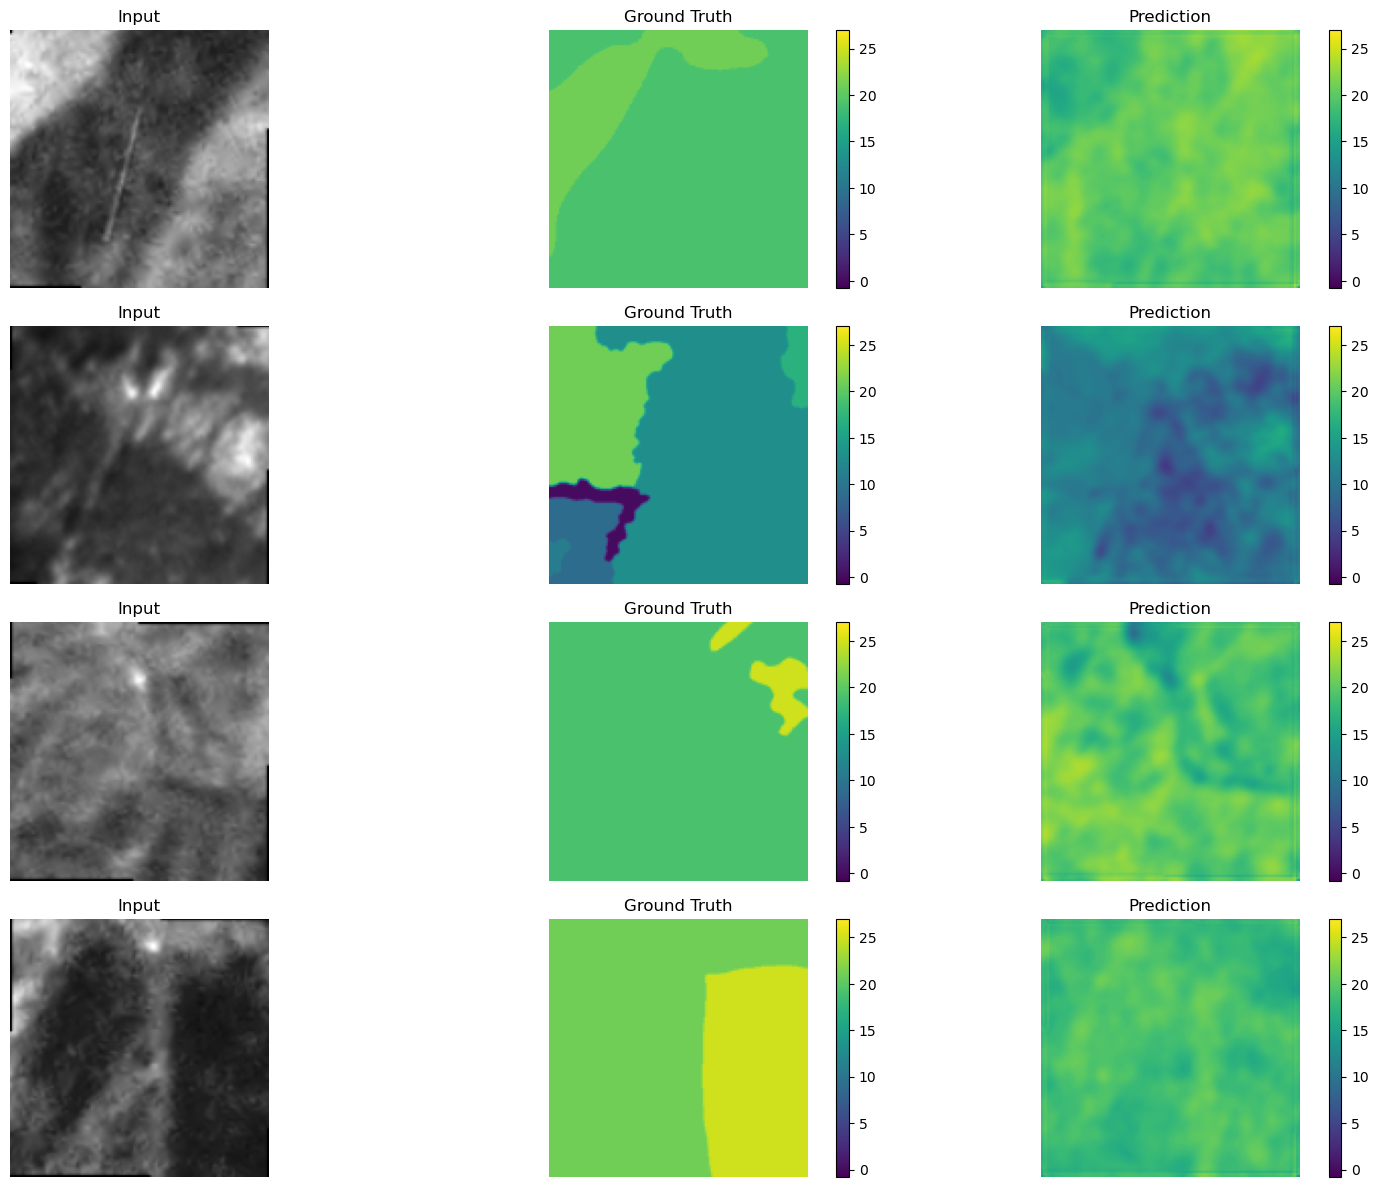

Epoch 1/10, Train Loss: 240.0145, Val Loss: 31.5969
Epoch 2/10, Train Loss: 29.3521, Val Loss: 36.1433
Epoch 3/10, Train Loss: 700.4471, Val Loss: 32.6380
Epoch 4/10, Train Loss: 35.7324, Val Loss: 41.0669
Epoch 5/10, Train Loss: 29.7944, Val Loss: 28.7744
Epoch 6/10, Train Loss: 27.5300, Val Loss: 27.2129
Epoch 7/10, Train Loss: 25.8443, Val Loss: 26.3063
Epoch 8/10, Train Loss: 98847276.5292, Val Loss: 96.6940
Epoch 9/10, Train Loss: 78.3268, Val Loss: 48.1761
Epoch 10/10, Train Loss: 31.7720, Val Loss: 28.5194


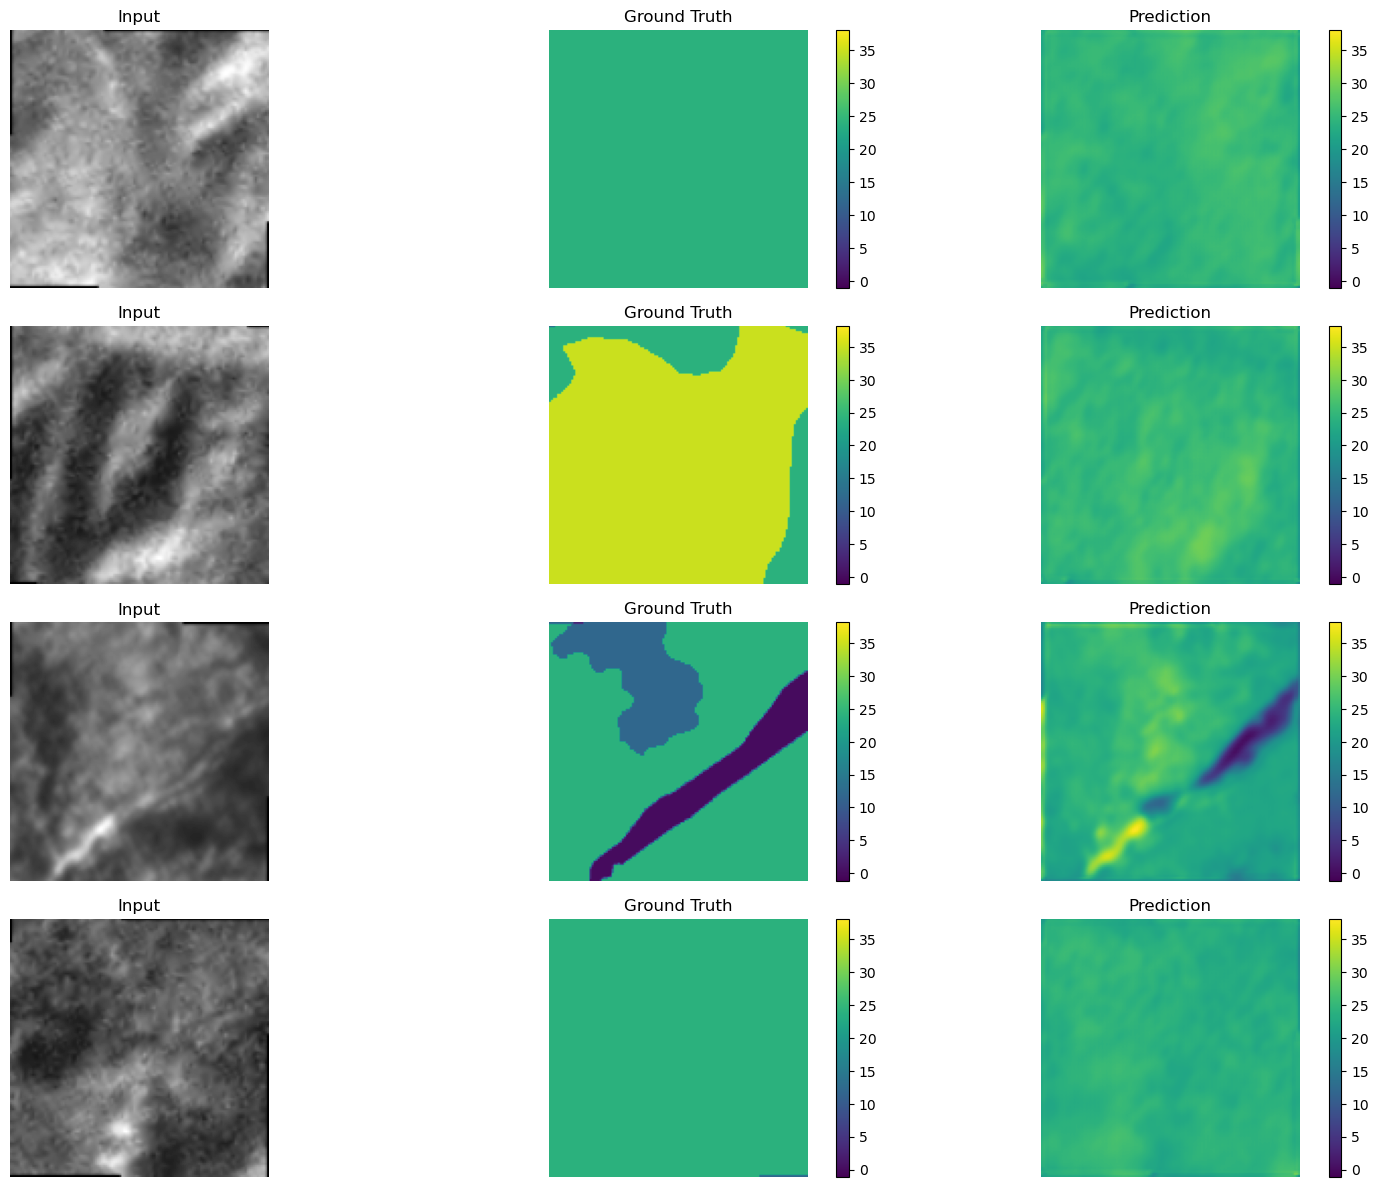

Epoch 1/10, Train Loss: 1770.7283, Val Loss: 162.5430
Epoch 2/10, Train Loss: 308.1796, Val Loss: 457.0298
Epoch 3/10, Train Loss: 358.7411, Val Loss: 175.9145
Epoch 4/10, Train Loss: 127.0967, Val Loss: 125.0155
Epoch 5/10, Train Loss: 120.7231, Val Loss: 152.4092
Epoch 6/10, Train Loss: 118.1552, Val Loss: 108.1456
Epoch 7/10, Train Loss: 113.0056, Val Loss: 103.5100
Epoch 8/10, Train Loss: 109.0313, Val Loss: 133.5265
Epoch 9/10, Train Loss: 215.4685, Val Loss: 116.0205
Epoch 10/10, Train Loss: 115.7777, Val Loss: 152.1729


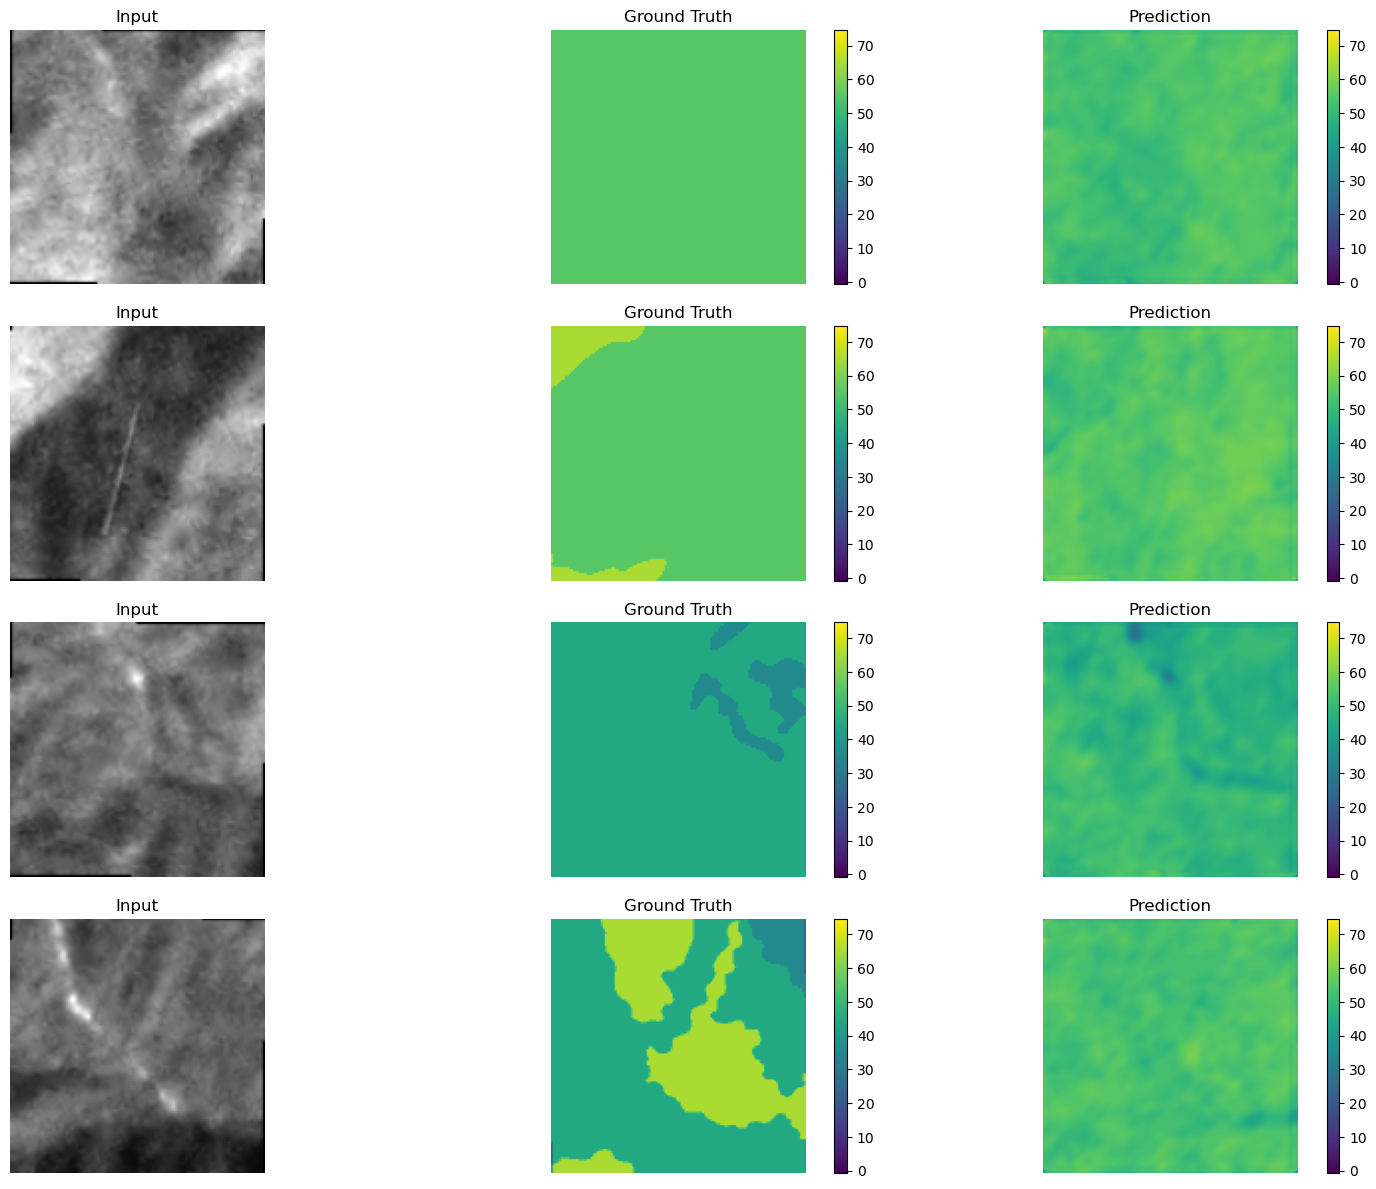

In [ ]:
for target_name in target[1:]:
    best_model, train_losses, val_losses = train_model(model[target_name], criterion[target_name], optimizer[target_name], train_loader[target_name], val_loader[target_name], epochs)
    # Save the best model
    # 모델을 평가 모드로 전환
    best_model.eval()
    model_save_path = f"./{target_name}_{epochs}.pth"
    torch.save(best_model, model_save_path)

    visualize_result(best_model, val_loader[target_name], "regression")

결과를 확인

수종

In [ ]:
model_species = torch.load("./수종_30.pth")

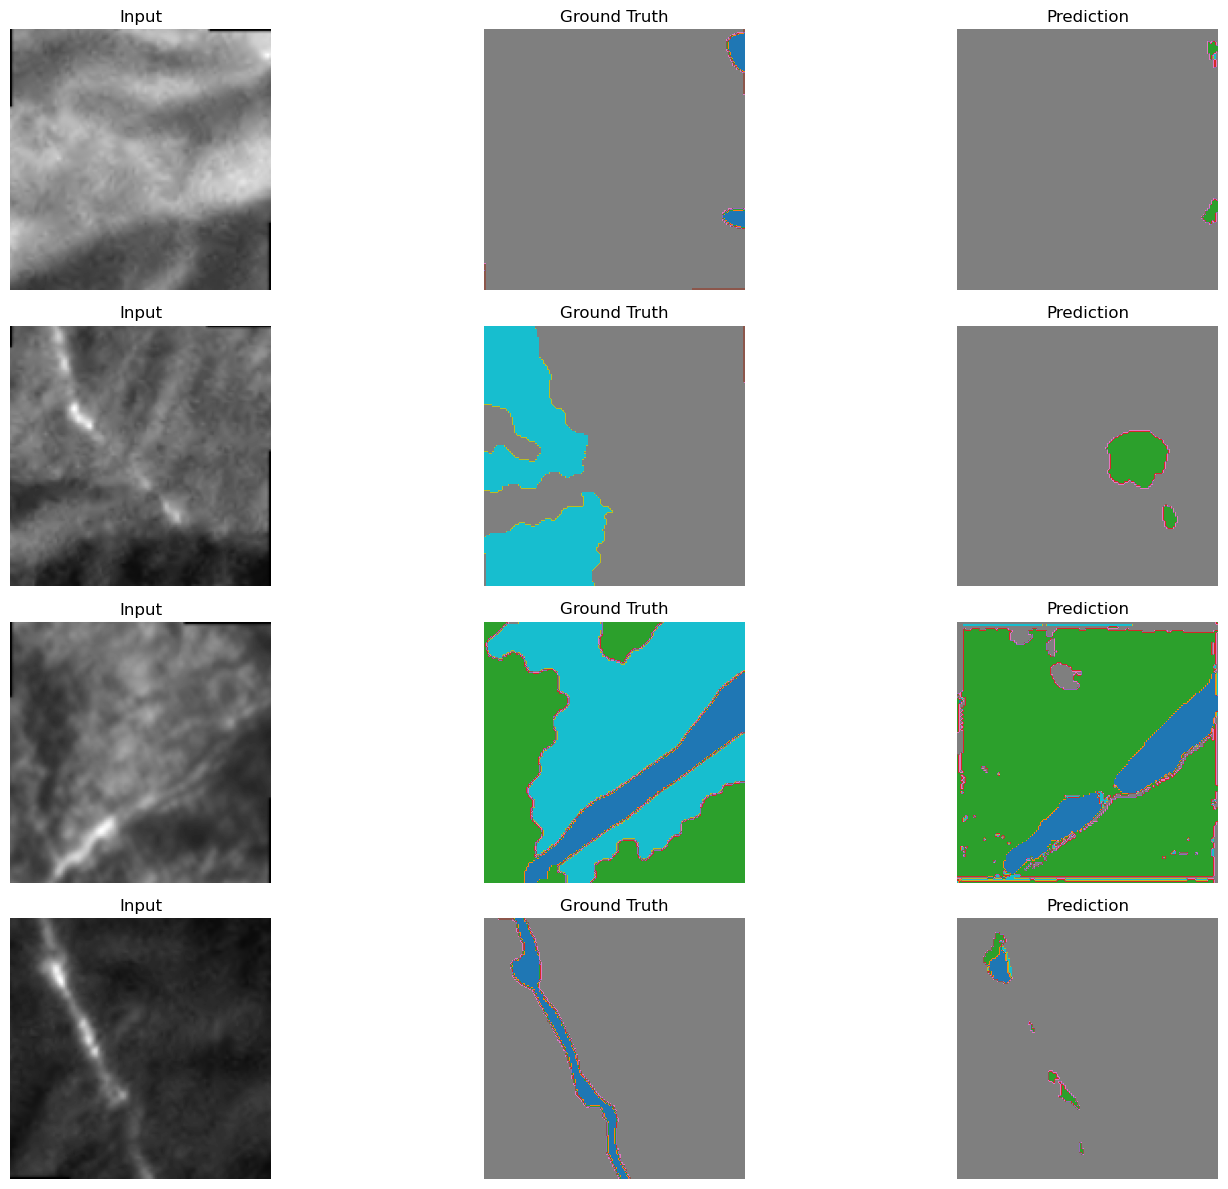

In [ ]:
visualize_result(model_species, val_loader["수종"], "segmentation")

c:\Users\taebin\anaconda3\Lib\site-packages\rasterio\__init__.py:319: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


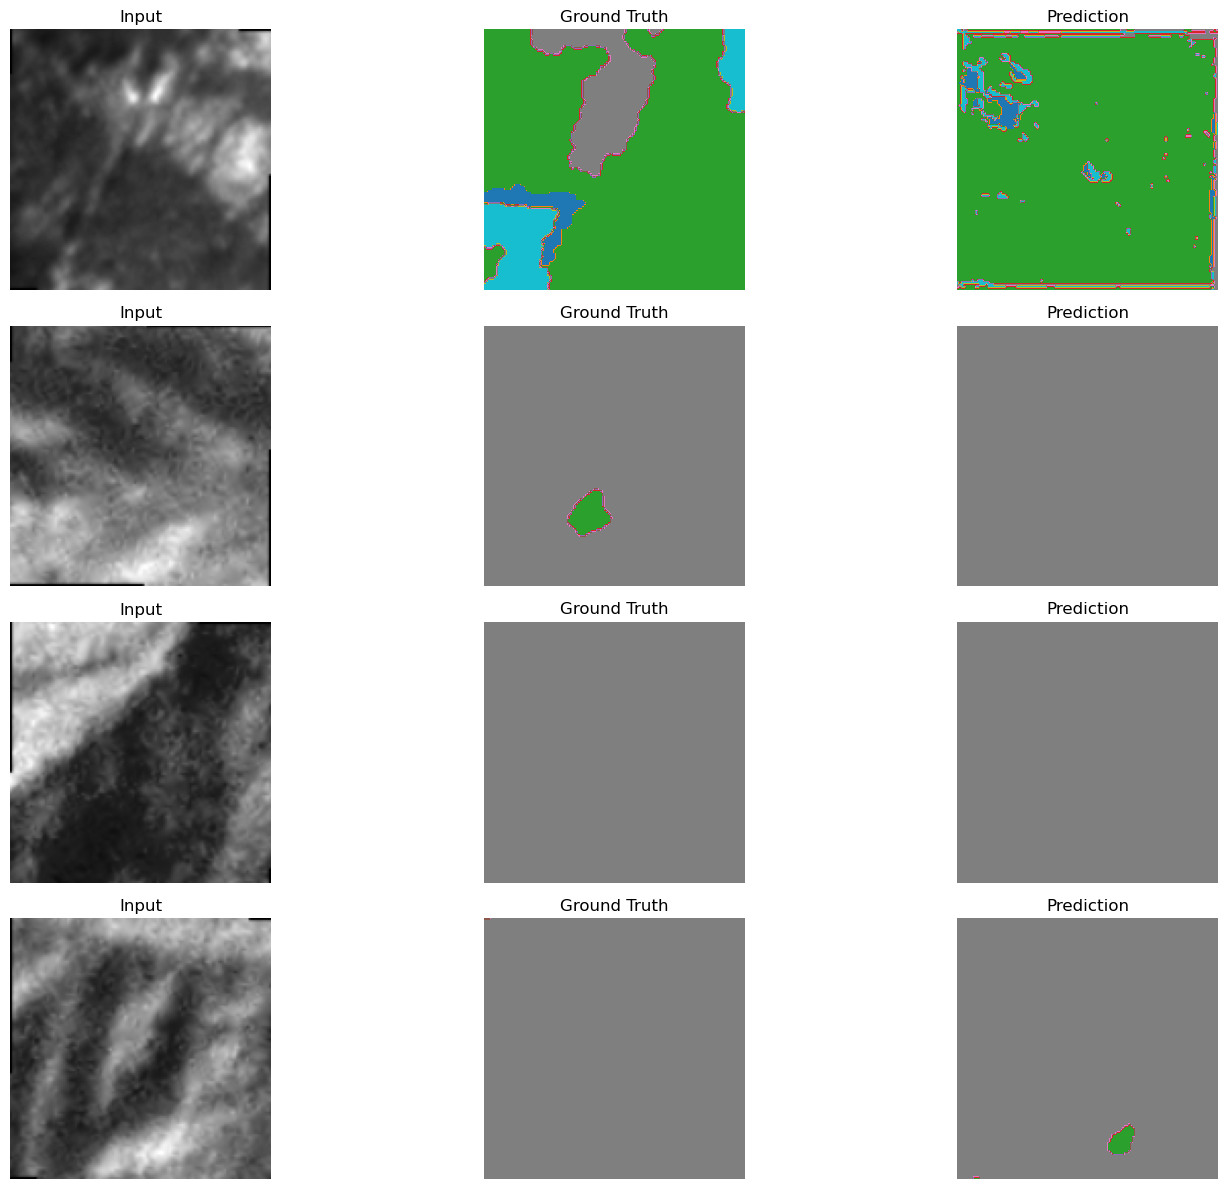

In [ ]:
visualize_result(model_species, val_loader["수종"], "segmentation")

흉고직경

In [ ]:
model_dbh = torch.load("./경급_10.pth")

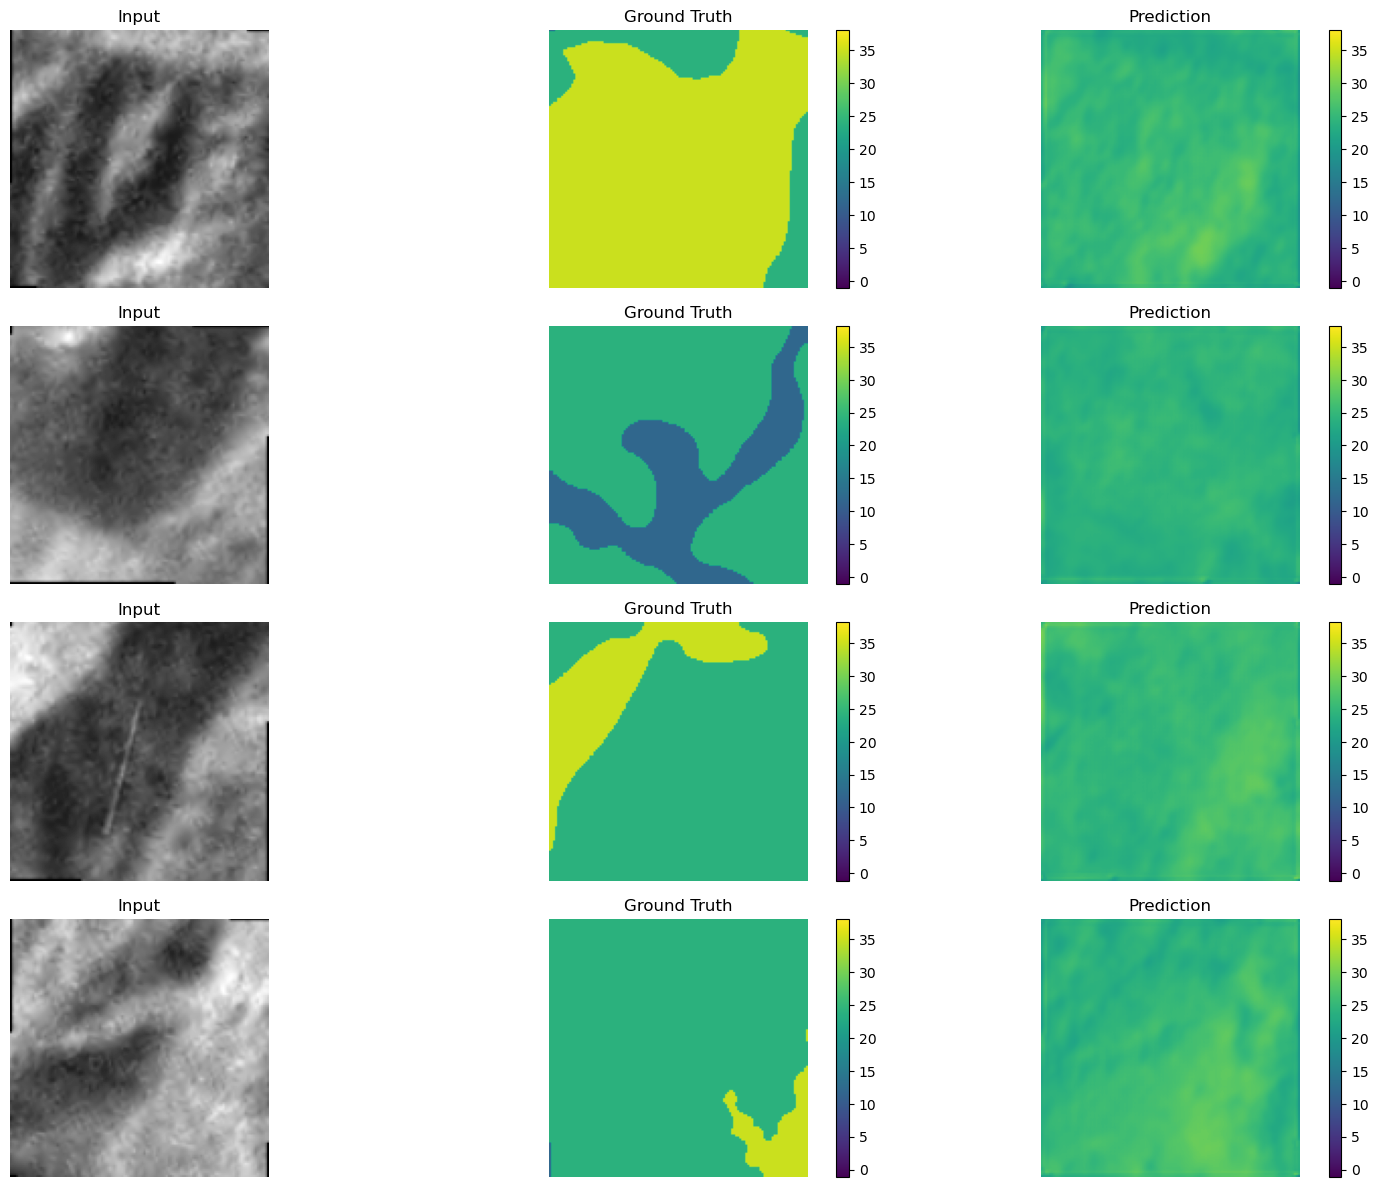

In [ ]:
visualize_result(model_dbh, val_loader["경급"], "regression")

임분고

In [ ]:
model_height = torch.load("./임분고_10.pth")

c:\Users\taebin\anaconda3\Lib\site-packages\rasterio\__init__.py:319: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


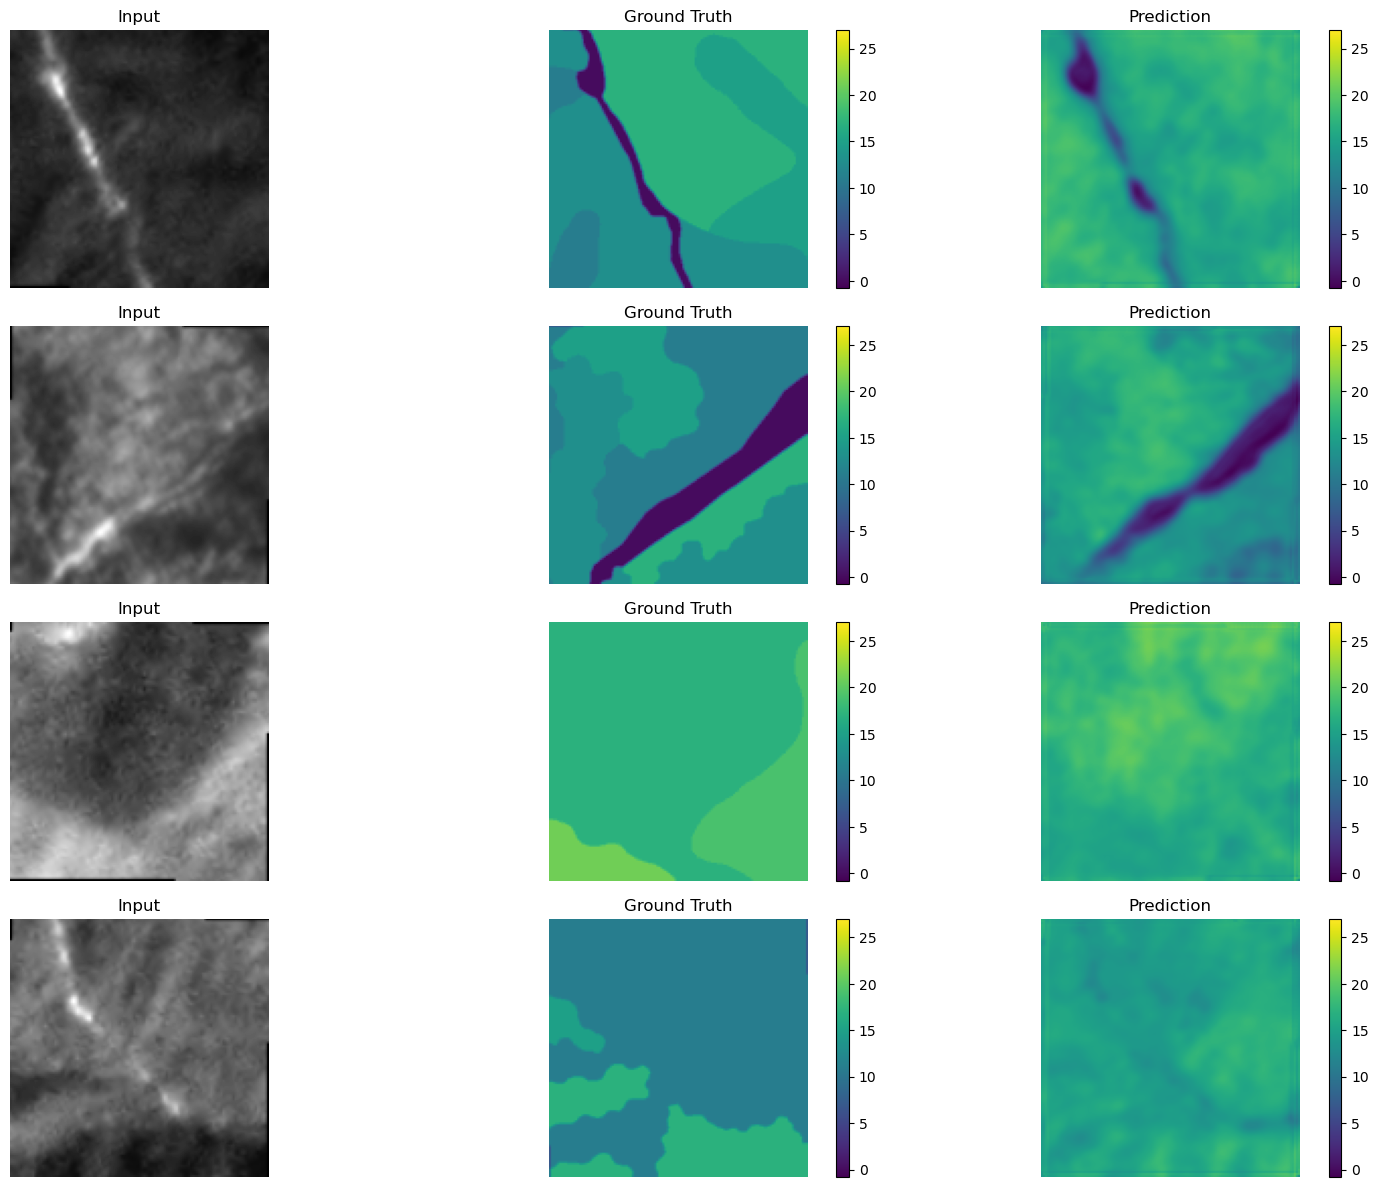

In [ ]:
visualize_result(model_height, val_loader["임분고"], "regression")

임령

In [ ]:
model_age = torch.load("./영급_10.pth")

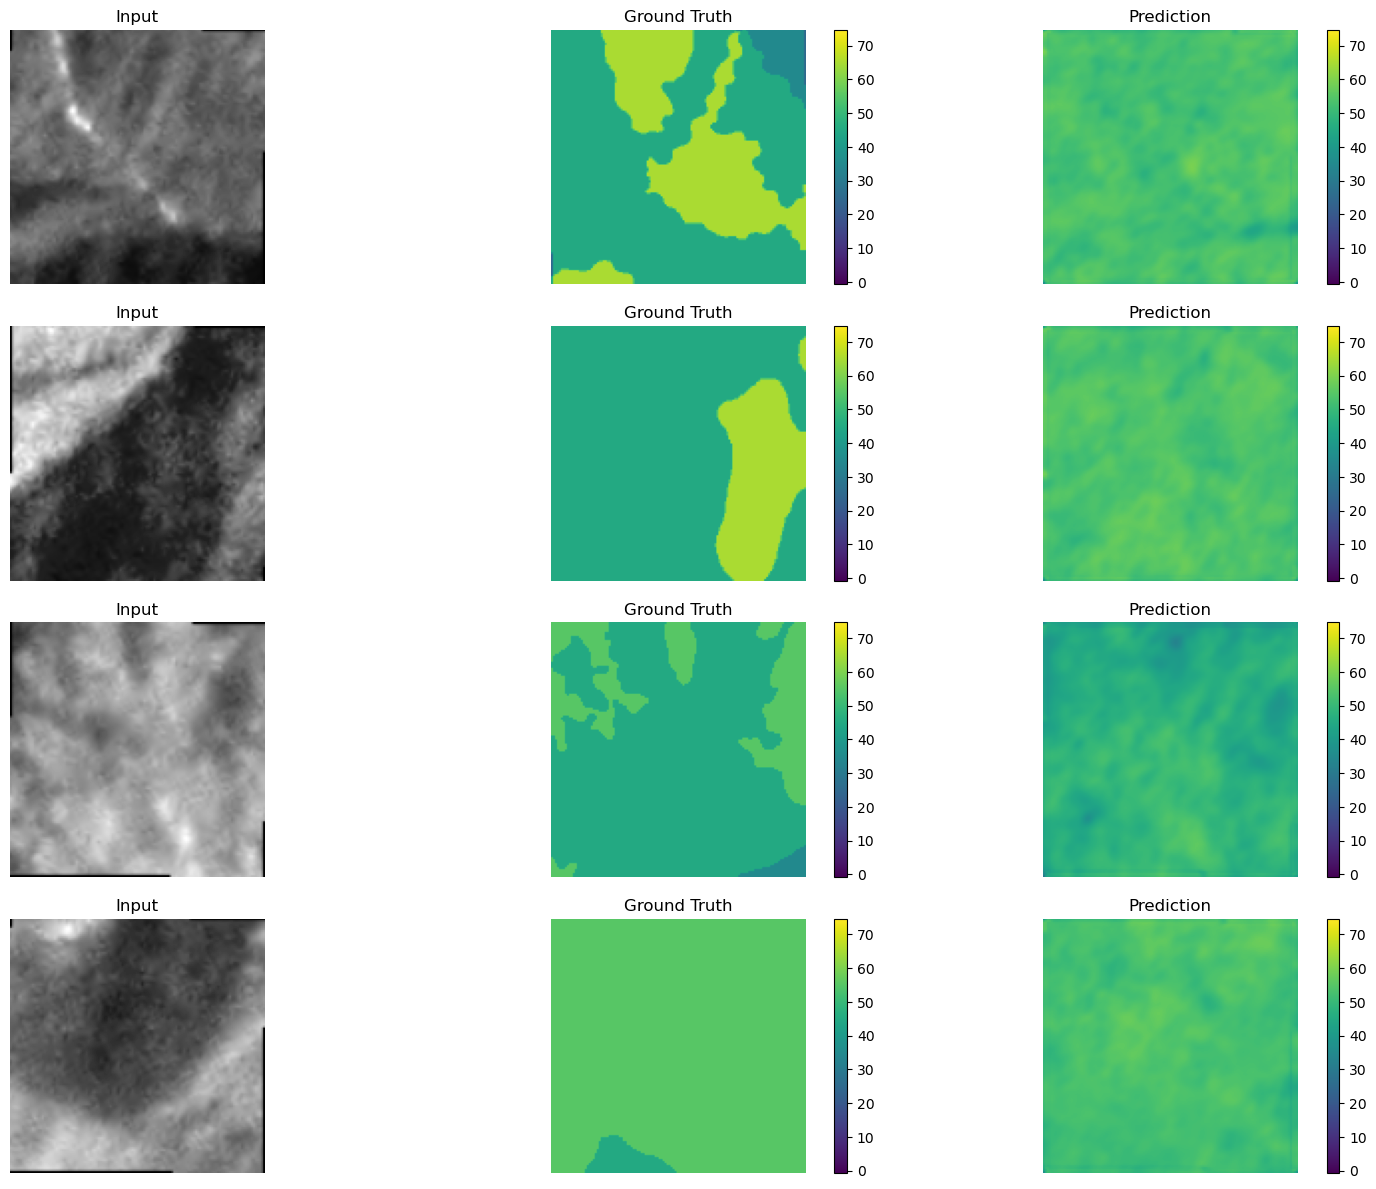

In [ ]:
visualize_result(model_age, val_loader["영급"], "regression")